In [ ]:
!pip install kaggle   # this is to install the kaggle api to access their library

In [ ]:
import json, os

username = "username"
key = "upload own kaggle key"

# Create .kaggle folder
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Write the kaggle.json file
kaggle_dict = {
    "username": username,
    "key": key
}

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_dict, f)

# Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/medical-mnist # Download dataset from Kaggle

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/medical-mnist
License(s): other
  0% 0.00/84.8M [00:00<?, ?B/s]
100% 84.8M/84.8M [00:00<00:00, 1.52GB/s]


In [ ]:
!unzip /content/medical-mnist.zip -d /content/medical-mnist # Unzip the dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/medical-mnist/HeadCT/005000.jpeg  
  inflating: /content/medical-mnist/HeadCT/005001.jpeg  
  inflating: /content/medical-mnist/HeadCT/005002.jpeg  
  inflating: /content/medical-mnist/HeadCT/005003.jpeg  
  inflating: /content/medical-mnist/HeadCT/005004.jpeg  
  inflating: /content/medical-mnist/HeadCT/005005.jpeg  
  inflating: /content/medical-mnist/HeadCT/005006.jpeg  
  inflating: /content/medical-mnist/HeadCT/005007.jpeg  
  inflating: /content/medical-mnist/HeadCT/005008.jpeg  
  inflating: /content/medical-mnist/HeadCT/005009.jpeg  
  inflating: /content/medical-mnist/HeadCT/005010.jpeg  
  inflating: /content/medical-mnist/HeadCT/005011.jpeg  
  inflating: /content/medical-mnist/HeadCT/005012.jpeg  
  inflating: /content/medical-mnist/HeadCT/005013.jpeg  
  inflating: /content/medical-mnist/HeadCT/005014.jpeg  
  inflating: /content/medical-mnist/HeadCT/005015.jpeg  
  inflating: /content/medical-mnist/H

# **Building a Convolutional NN to Classify Medical Images**

Using a dataset from Kaggle, we will build, train, and optimize a model.

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Import Dataset #

The dataset consists of 58954 medical images belonging to 6 classes. There are 6 subfolders to load data from.


*   The image_dataset_from_directory() function from TensorFlow's keras API automatically loads and labels images from a directory structure.

The dataset will be split into 3 subsets:


*   Training set
*   Cross-validation set
*   Testing set

We will train a model on the training set, then select a model based on the cross-validation set and test the selected model based on the testing set.


In [ ]:
dataset_directory = '/content/medical-mnist'

# Define target image dimensions for resizing
img_height = 64
img_width = 64

# Load the training portion of the dataset
# 60% of the images will be used for training
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    image_size=(img_height, img_width),
    labels='inferred',      # Automatically assign labels based on folder structure
    shuffle=True,           # Randomize image order
    validation_split=0.4,   # Reserve 40% for validation + testing
    subset="training",      # Select the training split (60%)
    seed=123                # Fixed seed for consistent splits
)

# Load the remaining 40% of the dataset
# This portion will later be divided into validation and test sets
validation_and_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    image_size=(img_height, img_width),
    labels='inferred',
    shuffle=True,           # Shuffle to avoid ordering bias
    validation_split=0.4,   # Same split ratio as above
    subset="validation",    # Select the held-out data
    seed=123                # Must match training seed
)

# Divide the held-out data evenly into validation and test sets
# Each will represent 20% of the full dataset

# Calculate split sizes
validation_size = len(validation_and_test_dataset) // 2
test_size = len(validation_and_test_dataset) - validation_size

# Use the first half for model validation
X_cv = validation_and_test_dataset.take(validation_size)

# Use the remaining half for final testing
X_test = validation_and_test_dataset.skip(validation_size)

# Final dataset breakdown:
# Training set: 60%
# Validation set: 20%
# Test set: 20%


Found 58954 files belonging to 6 classes.
Using 35373 files for training.
Found 58954 files belonging to 6 classes.
Using 23581 files for validation.


# Visualize the Data #

Print the first 6 images to visualize the data we are working with.


*   take() method extracts a given number of elements from the dataset
*   By default, we work in batches of 32, but we will only show the first 6 images

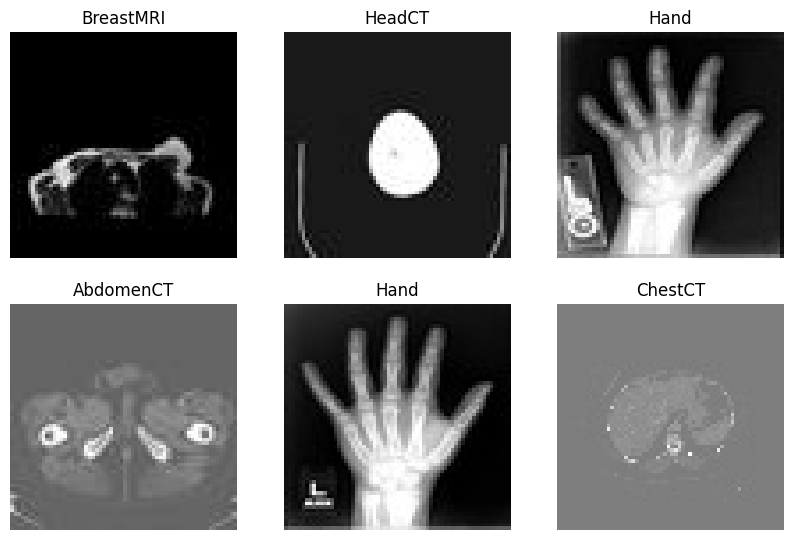

In [ ]:
import matplotlib.pyplot as plt

# Create a figure to display multiple images at once
# The figure size controls the overall width and height of the plot
plt.figure(figsize=(10, 10))

# Retrieve a single batch of images from the training dataset
# Each batch typically contains 32 images with shape (64, 64, 3)
for images, labels in X_train.take(1):

    # Loop through the first 6 images in the batch
    for i in range(6):

        # Create a subplot in a 3x3 grid (only 6 slots will be used)
        ax = plt.subplot(3, 3, i + 1)

        # Display the image after converting pixel values to unsigned integers
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of each subplot to the corresponding class label
        plt.title(X_train.class_names[labels[i]])

        # Hide axis ticks and labels for cleaner visualization
        plt.axis("off")


# Build Initial Model #

Models considered were LeNet-5, AlexNet, and VGG-16, but opted for AlexNet to balance in factors such as performance and resource usage.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
# This model serves as the initial CNN architecture for image classification
# Determine the number of output classes based on the training dataset
num_classes = len(X_train.class_names)

# Build the initial Convolutional Neural Network (CNN) model
model = Sequential([

    # Normalize input image pixel values from [0, 255] to [0, 1]
    # This helps stabilize and speed up training
    tf.keras.layers.Rescaling(1./255),

    # Convolution 1
    # Apply 32 convolution filters of size 5x5 to extract low-level features
    # such as edges and textures from the input images
    tf.keras.layers.Conv2D(
        32, (5, 5),
        strides=1,
        activation='relu',
        input_shape=(img_height, img_width, 3)
    ),

    # Downsample the feature maps to reduce spatial dimensions
    # and computational complexity
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    # Convolution 2
    # Increase the number of filters to capture more complex patterns
    # Padding keeps the spatial dimensions consistent
    tf.keras.layers.Conv2D(
        64, (3, 3),
        padding='same',
        activation='relu'
    ),

    # Further reduce feature map size
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    # Convolution 3
    # Deeper convolution layer to learn higher-level visual features
    tf.keras.layers.Conv2D(
        128, (3, 3),
        activation='relu'
    ),

    # Convolution 4
    # Additional convolution to further refine extracted features
    tf.keras.layers.Conv2D(
        128, (3, 3),
        activation='relu'
    ),

    # Convolution 2
    # Reduce the number of filters before pooling to balance complexity
    tf.keras.layers.Conv2D(
        64, (3, 3),
        activation='relu'
    ),

    # Final pooling layer to condense spatial information
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    # Flatten layer
    # Convert 2D feature maps into a 1D feature vector
    # to prepare for fully connected layers
    tf.keras.layers.Flatten(),

    # Connect the layers
    # Dense layer to learn non-linear combinations of features
    tf.keras.layers.Dense(1024, activation='relu'),

    # Dropout helps prevent overfitting by randomly disabling neurons
    tf.keras.layers.Dropout(0.5),

    # Second dense layer to further refine learned representations
    tf.keras.layers.Dense(1024, activation='relu'),

    # Additional dropout for regularization
    tf.keras.layers.Dropout(0.5),

    # output layer
    # Final layer produces class probabilities using softmax
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the Model

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# The metrics argument is to view training and validation accuracy for each training epoch

model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


# Train the Model

In [ ]:
loss_plot = model.fit(X_train, epochs=10, validation_data=(X_cv))

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1106/1106 ━━━━━━━━━━━━━━━━━━━━ 485s 435ms/step - accuracy: 0.8747 - loss: 0.3379 - val_accuracy: 0.9924 - val_loss: 0.0335
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 477s 432ms/step - accuracy: 0.9894 - loss: 0.0380 - val_accuracy: 0.9979 - val_loss: 0.0117
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 474s 429ms/step - accuracy: 0.9934 - loss: 0.0225 - val_accuracy: 0.9978 - val_loss: 0.0098
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 473s 427ms/step - accuracy: 0.9956 - loss: 0.0170 - val_accuracy: 0.9957 - val_loss: 0.0210
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 511s 436ms/step - accuracy: 0.9964 - loss: 0.0172 - val_accuracy: 0.9969 - val_loss: 0.0139
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 495s 429ms/step - accuracy: 0.9951 - loss: 0.0194 - val_accuracy: 0.9985 - val_loss: 0.0063
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 502s 429ms/step - accuracy: 0.9952 - loss: 0.0196 - val_accuracy: 0.9952 - val_loss: 0.0256
Epoch 8/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 472s 427ms/step - accuracy: 0.9

# Visualize Loss to Asses Generalization

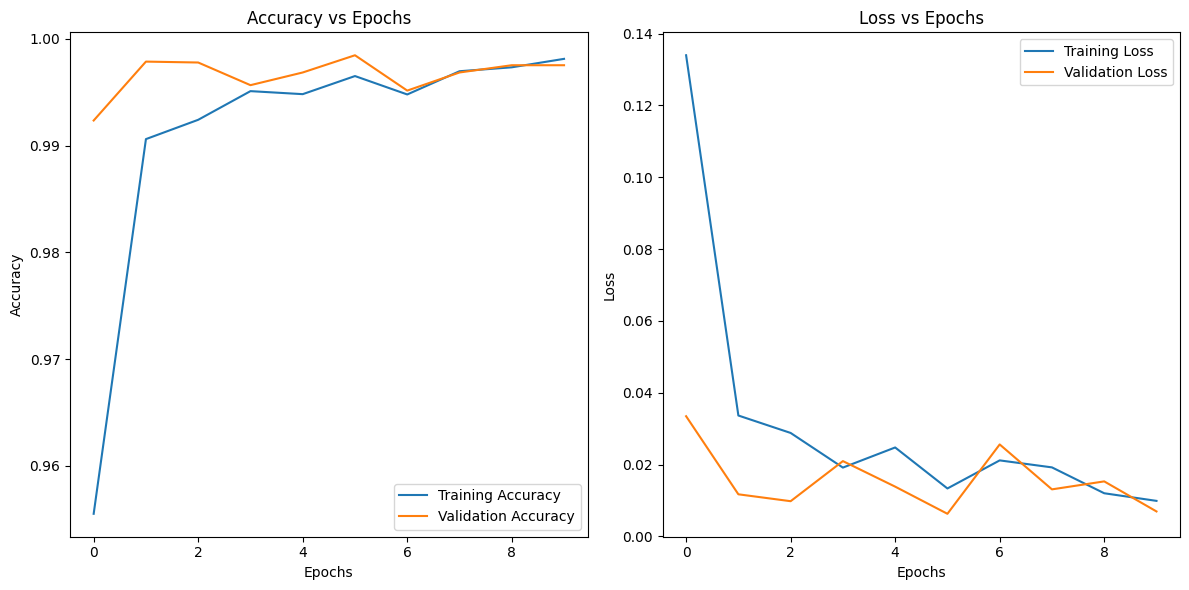

In [ ]:
# two subplots (accuracy and loss)
# figure size controls the overall width and height of the plots
plt.figure(figsize=(12, 6))

# Accuracy Plot
# Create the first subplot (1 row, 2 columns, position 1)
plt.subplot(1, 2, 1)

# Plot training accuracy across epochs
plt.plot(loss_plot.history['accuracy'], label='Training Accuracy')

# Plot validation accuracy across epochs
plt.plot(loss_plot.history['val_accuracy'], label='Validation Accuracy')

# Add title and axis labels for clarity
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display legend to distinguish training vs validation curves
plt.legend()

# Loss Plot
# Create the second subplot (1 row, 2 columns, position 2)
plt.subplot(1, 2, 2)

# Plot training loss across epochs
plt.plot(loss_plot.history['loss'], label='Training Loss')

# Plot validation loss across epochs
plt.plot(loss_plot.history['val_loss'], label='Validation Loss')

# Add title and axis labels for clarity
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display legend to distinguish training vs validation curves
plt.legend()

# Adjust spacing between subplots to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test)

369/369 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.9982 - loss: 0.0065


#Predict the first 3 images of test set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Create an iterator for the test dataset
test_iter = iter(X_test)

# Get the first batch of test images and their corresponding labels
batch_images, batch_labels = next(test_iter)


# Extract the first 3 images from the batch
first_three_images = batch_images[:3]
# Extract the true labels corresponding to those images
first_three_labels = batch_labels[:3]


# Generate prediction probabilities for each image
predictions = model.predict(first_three_images)
# Convert probability distributions into predicted class indices
predicted_labels = np.argmax(predictions, axis=1)

# Print the true labels and predicted labels
print("True labels:", first_three_labels)
print("Predicted labels:", predicted_labels)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
True labels: tf.Tensor([1 4 1], shape=(3,), dtype=int32)
Predicted labels: [1 4 1]
